In [1]:
import fvdb
from fvdb.nn import VDBTensor
import torch
from UNet import SparseUNet
import matplotlib.pyplot as plt
from IPython import display
from utils import setup_plots, update_plots

#fvdb.nn.SparseConv3d.allow_tf32 = False

In [2]:
from torch.utils.data import Dataset
import os

class ChunkDataset(Dataset):
    def __init__(self, chunksPath):
        self.paths = []

        for filename in os.listdir(chunksPath):
            self.paths.append(f"{chunksPath}/{filename}")

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        grid_batch, labels, names = fvdb.load(self.paths[idx])
        labels.to(torch.long)

        return VDBTensor(grid_batch, labels)

In [3]:
dataset = ChunkDataset("data/training_data/chunks")

train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [4]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, collate_fn=fvdb.jcat, shuffle=True, prefetch_factor=4, num_workers=2)

num_classes = 0
with open("minecraft-serialization/block_list.txt", 'r') as file:
    num_classes = sum(1 for line in file)

model = SparseUNet(num_classes).to('cuda')
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

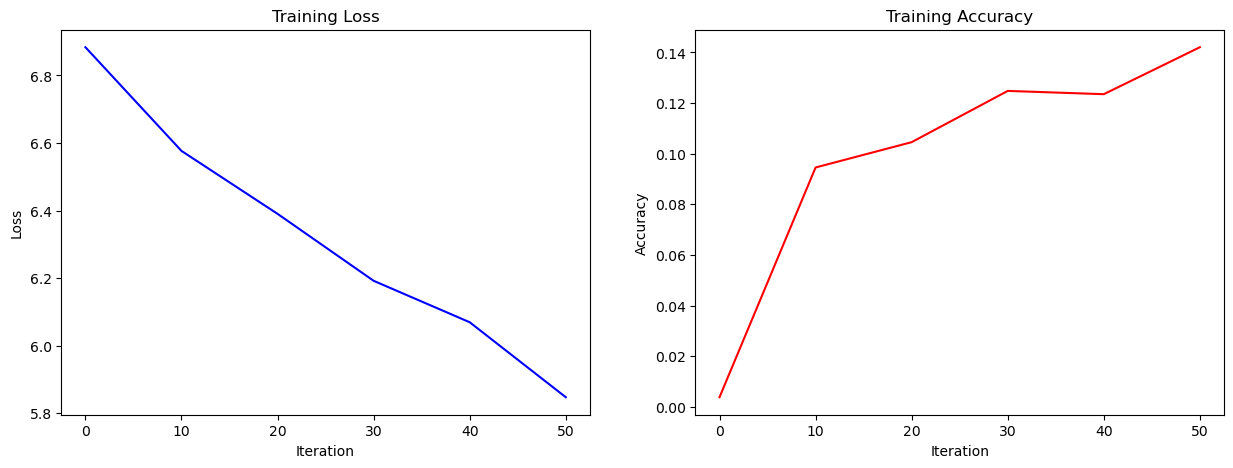

KeyboardInterrupt: 

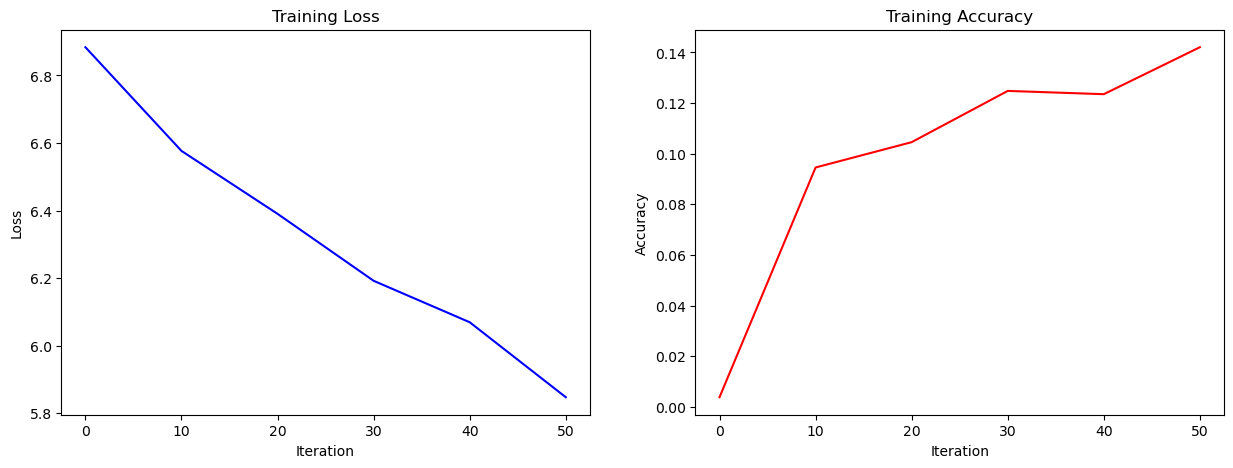

In [5]:
ax1, ax2, loss_line, acc_line = setup_plots()

losses = []
accuracies = []
iterations = []
epochs = 5
update_every = 10

# Training Loop
for epoch in range(epochs):
    for i, vdb_tensor in enumerate(train_loader):
        vdb_tensor = vdb_tensor.cuda()
        target = vdb_tensor.data.jdata.squeeze().to(torch.long)
        actives = vdb_tensor.grid.jagged_like(torch.ones(target.shape[0], device='cuda', dtype=torch.float32).unsqueeze(1))

        X = VDBTensor(grid=vdb_tensor.grid, data=actives)
        optimizer.zero_grad()
        y_hat = model(X)

        l = loss(y_hat.data.jdata, target)
        
        # Calculate accuracy
        predictions = torch.argmax(y_hat.data.jdata, dim=1)
        acc = (predictions == target).float().mean()

        l.backward()
        optimizer.step()

        if i % update_every == 0:
            losses.append(l.item())
            accuracies.append(acc.item())
            iterations.append(i)
            update_plots(losses, accuracies, iterations, ax1, ax2, loss_line, acc_line)